In [ ]:
!pip install torchopt torchsummary deepxde pydoe

In [ ]:
%env DDE_BACKEND=pytorch

env: DDE_BACKEND=pytorch


In [ ]:
import torch
from torch import nn
import numpy as np
from torch.func import functional_call, grad, vmap
import torchopt
from collections import OrderedDict
import matplotlib.pyplot as plt
import deepxde as dde
from pyDOE import lhs
from torch.optim import LBFGS
from torchsummary import summary
import scipy
from sklearn.model_selection import train_test_split
from matplotlib.animation import FuncAnimation
# import mlflow
# from siren_pytorch import SirenNet
# from siren_pytorch import Sine
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root = "/content/drive/MyDrive/PINN/"

### Dimensiones de sistema

In [ ]:
width = 2.2 # Largo de conducto
height = 0.41 # Alto de conducto

### Coordenadas de cilindro

In [ ]:
circle_center_x = 0.2
circle_center_y = 0.2
circle_radius = 0.05

### Propiedades de fluido

In [ ]:
U = 0.3 # Velocidad de entrada

In [ ]:
kinematic_viscocity = 0.001 # Viscocidad cinemática

### Cantidad de puntos de entrenamiento

In [ ]:
n_train_bc = 100

### Selección de dispositivo entre CPU y GPU para entrenamiento

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Puntos para condiciones de frontera

In [ ]:
# Función para determinar si un punto está dentro del cilindro
def inside_circle_condition(x_orig, y_orig, r, x, y):
    return (x - x_orig) ** 2 + (y - y_orig) ** 2 < r ** 2

In [ ]:
def circle_condition(x_orig, y_orig, r, x, y):
    return (x - x_orig) ** 2 + (y - y_orig) ** 2 == r ** 2

In [ ]:
# Función para obtener los puntos en el contorno del cilindro
def set_circle_data(x_orig, y_orig, r, n_circle):
    theta = np.linspace(0, 2 * np.pi, n_circle)
    x_circle = x_orig + r * np.cos(theta)
    y_circle = y_orig + r * np.sin(theta)
    x_circle = np.hstack((x_circle[:, None], y_circle[:, None]))
    u_circle = np.zeros((x_circle.shape))
    return x_circle, u_circle


In [ ]:
# Función para obtener los puntos en el contorno del rectángulo
def set_lower_and_upper_walls_boundary(x, y):
    x_up = np.hstack([x[0, :][:, None], y[0, :][:, None]])
    u_up = np.zeros((x_up.shape))

    x_low = np.hstack([x[-1, :][:, None], y[-1, :][:, None]])
    u_low = np.zeros((x_low.shape))

    return x_up, u_up, x_low, u_low


In [ ]:
# Función para obtener el valor de la velocidad del fluido que ingresa al conducto
def inflow(x, y):
    u_0_y = (4 * U * y * (height - y)) / (height ** 2)
    return u_0_y

In [ ]:
# Función para obtener los puntos en la condición de frontera de entrada de fluido al conducto
def set_left_wall_boundary(x, y):
    x_left = np.hstack([x[:, 0][:, None], y[:, 0][:, None]])
    u_left_y = inflow(x_left[:, 0], x_left[:, 1])
    u_left = np.hstack([u_left_y[:, None], np.zeros_like(u_left_y)[:, None]])

    return x_left, u_left

In [ ]:
# Función para crear tensores a partir de arreglos
def create_tensors(arrays):
  tensors = []
  for array in arrays:
    array = torch.tensor(array, dtype=torch.float32, requires_grad=True)
    tensors.append(array)
  return tensors

In [ ]:
# Función para obtener los puntos de todas las condiciones de frontera
def get_data_conditions(n, x_orig, y_orig, r, n_circle):
    # Se obtiene un muestreo de puntos del dominio con LHS
    sample = lhs(2, samples=n)
    x = sample[:, 0] * width
    y = sample[:, 1] * height
    x.sort()
    y.sort()
    print(x.shape, y.shape)
    x, y = np.meshgrid(x, y)
    
    # Puntos en contorno del cilindro
    x_circle, u_circle = set_circle_data(x_orig, y_orig, r, n_circle)

    # Puntos en contorno del rectángulo
    x_up, u_up, x_low, u_low = set_lower_and_upper_walls_boundary(x, y)
    x_left, u_left = set_left_wall_boundary(x, y)

    # Se concatenan los puntos de todas las condiciones de frontera
    x = np.vstack([x_circle, x_up, x_low, x_left])
    u = np.vstack([u_circle, u_up, u_low, u_left]) # Valores ground truth para velocidad horizontal y vertical

    # Se hace la presión 0 en todos los puntos de frontera
    p_column = np.zeros(shape=(u.shape[0]))

    u = np.hstack([u, p_column[:, None]]) # Se agrega la columna de presión a los valores ground truth

    # Se eliminan los puntos que están dentro del cilindro
    mask = ~inside_circle_condition(x_orig, y_orig, r, x[:, 0], x[:, 1])
    x = x[mask]
    u = u[mask]



    return x, u

In [ ]:
n_circle = 40

In [ ]:
# Se obtienen los puntos de todas las condiciones de frontera
x_conditions, y_conditions = get_data_conditions(n_train_bc, circle_center_x, circle_center_y, circle_radius, n_circle)
x_conditions.shape

(100,) (100,)


(318, 2)

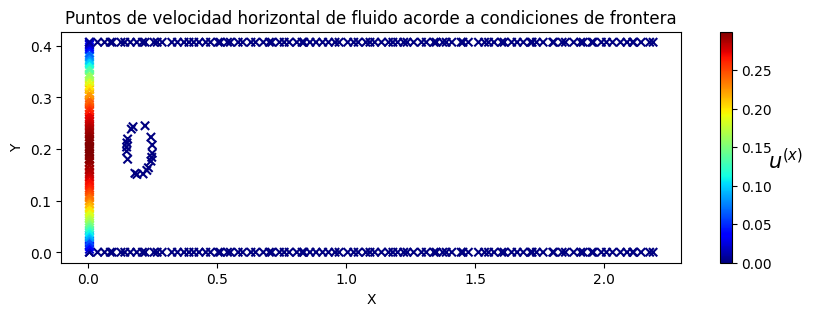

In [ ]:
plt.figure(figsize=(10, 3))
scatter = plt.scatter(x_conditions[:, 0], x_conditions[:, 1], cmap='jet', marker='x', c=y_conditions[:, 0])  # 'viridis' es un mapa de colores, pero puedes elegir otro
cbar = plt.colorbar(scatter)  # Muestra la barra de color
cbar.set_label(r'$u^{(x)}$', fontsize=15, rotation=0, labelpad=10)  # labelpad ajusta la distancia del texto a la barra
plt.title('Puntos de velocidad horizontal de fluido acorde a condiciones de frontera')
plt.xlabel('X')  # Etiqueta del eje X
plt.ylabel('Y')  # Etiqueta del eje Y

plt.savefig(root + 'ux-NS.pdf', format='pdf')

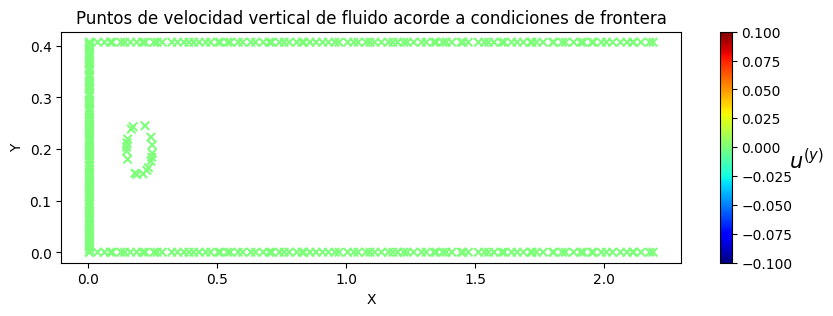

In [ ]:
plt.figure(figsize=(10, 3))
scatter = plt.scatter(x_conditions[:, 0], x_conditions[:, 1], cmap='jet', marker='x', c=y_conditions[:, 1])  # 'viridis' es un mapa de colores, pero puedes elegir otro
cbar = plt.colorbar(scatter)  # Muestra la barra de color
cbar.set_label(r'$u^{(y)}$', fontsize=15, rotation=0, labelpad=10)  # labelpad ajusta la distancia del texto a la barra
plt.title('Puntos de velocidad vertical de fluido acorde a condiciones de frontera')
plt.xlabel('X')  # Etiqueta del eje X
plt.ylabel('Y')  # Etiqueta del eje Y
plt.savefig(root + 'uy-NS.pdf', format='pdf')

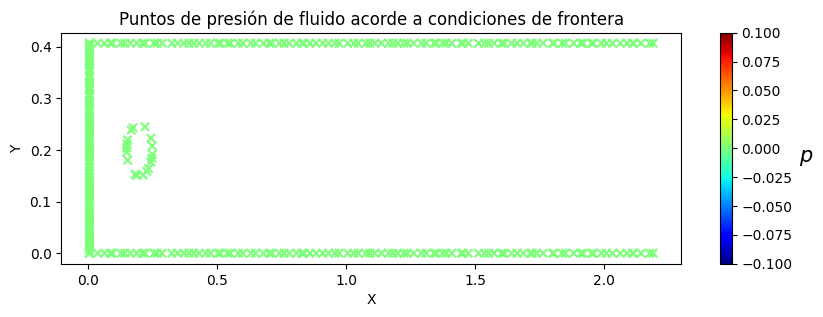

In [ ]:
plt.figure(figsize=(10, 3))
scatter = plt.scatter(x_conditions[:, 0], x_conditions[:, 1], cmap='jet', marker='x', c=y_conditions[:, 2])  # 'viridis' es un mapa de colores, pero puedes elegir otro
cbar = plt.colorbar(scatter)  # Muestra la barra de color
cbar.set_label(r'$p$', fontsize=15, rotation=0, labelpad=10)  # labelpad ajusta la distancia del texto a la barra
plt.title('Puntos de presión de fluido acorde a condiciones de frontera')
plt.xlabel('X')  # Etiqueta del eje X
plt.ylabel('Y')  # Etiqueta del eje Y
plt.savefig(root + 'p-NS.pdf', format='pdf')

In [ ]:
x_conditions, y_conditions = create_tensors([x_conditions, y_conditions])

### Red neuronal feedforward

In [ ]:
class FCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(FCN, self).__init__()
        activation = nn.Tanh

        layers = OrderedDict([
            ('input', nn.Linear(input_size, hidden_size)),
            ('act0', activation())
        ])

        # Añadiendo capas ocultas
        for i in range(num_layers):
            layers[f'hidden_{i}'] = nn.Linear(hidden_size, hidden_size)
            layers[f'act_{i}'] = activation()

        layers['output'] = nn.Linear(hidden_size, output_size)

        self.net = nn.Sequential(layers)

    def forward(self, x):
        return self.net(x)

In [ ]:
model = FCN(2, 50, 4, 3)
model.to(device)

FCN(
  (net): Sequential(
    (input): Linear(in_features=2, out_features=50, bias=True)
    (act0): Tanh()
    (hidden_0): Linear(in_features=50, out_features=50, bias=True)
    (act_0): Tanh()
    (hidden_1): Linear(in_features=50, out_features=50, bias=True)
    (act_1): Tanh()
    (hidden_2): Linear(in_features=50, out_features=50, bias=True)
    (act_2): Tanh()
    (hidden_3): Linear(in_features=50, out_features=50, bias=True)
    (act_3): Tanh()
    (output): Linear(in_features=50, out_features=3, bias=True)
  )
)

In [ ]:
summary(model, input_size=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]             150
              Tanh-2                   [-1, 50]               0
            Linear-3                   [-1, 50]           2,550
              Tanh-4                   [-1, 50]               0
            Linear-5                   [-1, 50]           2,550
              Tanh-6                   [-1, 50]               0
            Linear-7                   [-1, 50]           2,550
              Tanh-8                   [-1, 50]               0
            Linear-9                   [-1, 50]           2,550
             Tanh-10                   [-1, 50]               0
           Linear-11                    [-1, 3]             153
Total params: 10,503
Trainable params: 10,503
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [ ]:
loss_fn = nn.MSELoss()

In [ ]:
# def physics_loss(x_coll, y_coll):
#     x_coll = torch.hstack((x_coll, y_coll))
#     # print(x_coll)
#     y_hat = model(x_coll)

#     u_pred = y_hat[:, 0:1]
#     v_pred = y_hat[:, 1:2]
#     p_pred = y_hat[:, 2:3]

#     x = x_coll[:, 0].unsqueeze(1)
#     y = x_coll[:, 1].unsqueeze(1)

#     ux = dde.grad.jacobian(y_hat, x_coll, i=0, j=0)
#     uy = dde.grad.jacobian(y_hat, x_coll, i=0, j=1)

#     vx = dde.grad.jacobian(y_hat, x_coll, i=1, j=0)
#     vy = dde.grad.jacobian(y_hat, x_coll, i=1, j=1)

#     px = dde.grad.jacobian(y_hat, x_coll, i=2, j=0)
#     py = dde.grad.jacobian(y_hat, x_coll, i=2, j=1)

#     uxx = dde.grad.hessian(y_hat, x_coll, i=0, j=0)
#     uyy = dde.grad.hessian(y_hat, x_coll, i=0, j=1)

#     vxx = dde.grad.hessian(y_hat, x_coll, i=1, j=0)
#     vyy = dde.grad.hessian(y_hat, x_coll, i=1, j=1)

#     # Ecuaciones de Navier-Stokes para fluidos incompresibles
#     ns_x = -kinematic_viscocity * (uxx + uyy) + u_pred * ux + v_pred * uy + px
#     ns_y = -kinematic_viscocity * (vxx + vyy) + u_pred * vx + v_pred * vy + py

#     # Ecuación de continuidad para flujo incompresible
#     continuity = ux + vy

#     loss = loss_fn(ns_x, torch.zeros_like(ns_x)) + \
#         loss_fn(ns_y, torch.zeros_like(ns_y)) + \
#         loss_fn(continuity, torch.zeros_like(continuity))

#     return loss


In [ ]:
# Función que calcula la périda física en base a las PDE de Navier-Stokes
def physics_loss(x_coll, y_coll):
    data = torch.hstack((x_coll, y_coll))
    y_hat = model(data)

    # Se obtienen las predicciones de velocidad y presión
    u_pred = y_hat[:, 0:1]
    v_pred = y_hat[:, 1:2]
    p_pred = y_hat[:, 2:3]

    # Se obtienen las derivadas de las predicciones
    ux = torch.autograd.grad(u_pred, x_coll, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    uy = torch.autograd.grad(u_pred, y_coll, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    vx = torch.autograd.grad(v_pred, x_coll, grad_outputs=torch.ones_like(v_pred), create_graph=True)[0]
    vy = torch.autograd.grad(v_pred, y_coll, grad_outputs=torch.ones_like(v_pred), create_graph=True)[0]
    px = torch.autograd.grad(p_pred, x_coll, grad_outputs=torch.ones_like(p_pred), create_graph=True)[0]
    py = torch.autograd.grad(p_pred, y_coll, grad_outputs=torch.ones_like(p_pred), create_graph=True)[0]

    uxx = torch.autograd.grad(ux, x_coll, grad_outputs=torch.ones_like(ux), create_graph=True)[0]
    uyy = torch.autograd.grad(uy, y_coll, grad_outputs=torch.ones_like(uy), create_graph=True)[0]
    vxx = torch.autograd.grad(vx, x_coll, grad_outputs=torch.ones_like(vx), create_graph=True)[0]
    vyy = torch.autograd.grad(vy, y_coll, grad_outputs=torch.ones_like(vy), create_graph=True)[0]


    # Ecuaciones de Navier-Stokes para fluidos incompresibles
    ns_x = -kinematic_viscocity * (uxx + uyy) + u_pred * ux + v_pred * uy + px
    ns_y = -kinematic_viscocity * (vxx + vyy) + u_pred * vx + v_pred * vy + py

    # Ecuación de continuidad para flujo incompresible
    continuity = ux + vy

    # Suma los componentes de la pérdida
    loss = torch.mean(ns_x ** 2) + torch.mean(ns_y ** 2) + torch.mean(continuity ** 2)
    return loss


In [ ]:
# Función que calcula la pérdida en base a las condiciones de frontera 
def conditions_loss(x, y):
    y_hat = model(x)

    u_pred = y_hat[:, 0:1]
    v_pred = y_hat[:, 1:2]
    p_pred = y_hat[:, 2:3]

    u_real = y[:, 0:1]
    v_real = y[:, 1:2]
    p_real = y[:, 2:3]

    return loss_fn(u_pred, u_real) + loss_fn(v_pred, v_real)

In [ ]:
# Función que busca balancear las pérdidas de las PDE y las condiciones de frontera
def update_weights(physics_l, conditions_l, weights):

  lambda1 = weights['residual']
  lambda2 = weights['bc']

  grad_r = torch.autograd.grad(physics_l, model.parameters(), grad_outputs=torch.ones_like(physics_l), retain_graph=True, allow_unused=True)[0]
  grad_c = torch.autograd.grad(conditions_l, model.parameters(), grad_outputs=torch.ones_like(conditions_l), retain_graph=True)[0]

  gradients = grad_r.norm() + grad_c.norm()
  lambda1_hat = gradients / grad_r.norm()
  lambda2_hat = gradients / grad_c.norm()

  alpha = 0.9

  lambda1 = alpha * lambda1 + (1 - alpha) * lambda1_hat
  lambda2 = alpha * lambda2 + (1 - alpha) * lambda2_hat

  weights = {
      'residual': lambda1,
      'bc': lambda2
  }
  return weights

In [ ]:
# Función de pérdida total
def loss_func(x_bc, y_bc, x_collocation, y_collocation, weights, n, f, auto_w=False):
    # Se obtienen las pérdidas de las PDE y las condiciones de frontera
    physics_l = physics_loss(x_collocation, y_collocation)
    conditions_l = conditions_loss(x_bc, y_bc)

    # Se actualizan los pesos si se activa la opción de autoajuste
    if n % f == 0 and auto_w:
      weights = update_weights(physics_l, conditions_l, weights)

    w_physics = weights['residual']
    w_conditions = weights['bc']

    loss = w_physics * physics_l + w_conditions * conditions_l
    return loss, weights

In [ ]:
# Función para generar los puntos de colocación del modelo
def get_collocation_points(n_train, x_orig, y_orig, r):
    # Se obtiene un muestreo de puntos del dominio con LHS
    sample = lhs(2, samples=n_train)
    x = sample[:, 0] * width
    y = sample[:, 1] * height

    x, y = np.meshgrid(x, y)

    x_train = np.hstack((x.flatten()[:, None], y.flatten()[:, None]))

    # Se obtienen los puntos en el contorno del cilindro
    x_circle, _ = set_circle_data(x_orig, y_orig, r, 50)

    # Se eliminan los puntos que están dentro del cilindro
    mask = ~inside_circle_condition(x_orig, y_orig, r, x_train[:, 0], x_train[:, 1])

    x_train = x_train[mask]
    x_train = np.vstack((x_train, x_circle))

    x_train, y_train = x_train[:, 0], x_train[:, 1]
    x_train = x_train.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)

    plt.figure(figsize=(10, 3))
    plt.scatter(x_train, y_train, cmap='jet')
    plt.colorbar()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

    x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
    y_train = torch.tensor(y_train, dtype=torch.float32, requires_grad=True)

    return x_train, y_train

In [ ]:
n_train_coll = 150

<ipython-input-48-1e4f9dcfe01c>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_train, y_train, cmap='jet')


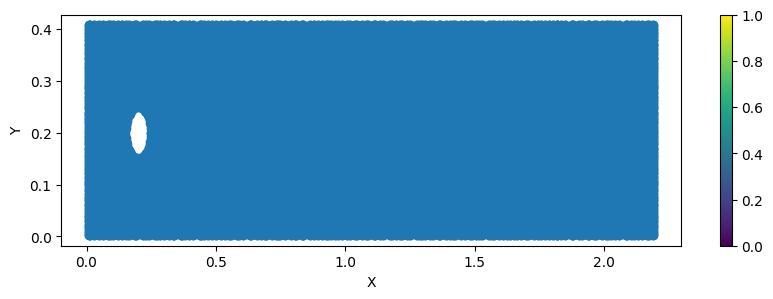

In [ ]:
x_collocation, y_collocation = get_collocation_points(n_train_coll, circle_center_x, circle_center_y, circle_radius)

In [ ]:
x_collocation.shape

torch.Size([22357, 1])

### Entrenamiento de red neuronal

In [ ]:
epochs_ADAM = 2000
epochs_LBFGS = 1000

total_epochs = epochs_ADAM + epochs_LBFGS

In [ ]:
optimizer_ADAM = torch.optim.Adam(params=model.parameters(), lr=0.001)
optimizer_LBFGS = torch.optim.LBFGS(params=model.parameters(), lr=0.1)

In [ ]:
x_conditions = x_conditions.to(device)
y_conditions = y_conditions.to(device)
x_collocation = x_collocation.to(device)
y_collocation = y_collocation.to(device)

In [ ]:
weights = {
    'residual': 1.0,
    'bc': 1.0
}

In [ ]:
f = 500

In [ ]:
loss_list = []

### Optimización conjunta con ADAM y L-BFGS

In [ ]:
for epoch in range(epochs_ADAM):
    optimizer_ADAM.zero_grad()
    loss, weights = loss_func(x_conditions, y_conditions, x_collocation, y_collocation, weights, epoch, f, True)
    loss.backward()
    optimizer_ADAM.step()
    loss_list.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}/{total_epochs}. Loss: {loss.item()}.")

for epoch in range(epochs_LBFGS):
    x_conditions = x_conditions.to(device)
    y_conditions = y_conditions.to(device)
    x_collocation = x_collocation.to(device)
    y_collocation = y_collocation.to(device)

    def closure():
        global weights, epoch, f
        # Limpiar los gradientes antes de calcular la pérdida
        optimizer_LBFGS.zero_grad()
        # Calcular la pérdida
        loss, weights = loss_func(x_conditions, y_conditions, x_collocation, y_collocation, weights, epoch, f)
        # Realizar el paso hacia atrás
        loss.backward()
        # Retornar la pérdida para que LBFGS pueda usarla
        return loss

    optimizer_LBFGS.step(closure)

    loss = closure()

    loss_list.append(loss.item())

    if epoch % (epochs_LBFGS//3) == 0:
        print(f"Epoch: {epochs_ADAM + epoch}/{total_epochs}. Loss: {loss.item()}.")

Epoch: 0/3000. Loss: 0.03741651028394699.
Epoch: 100/3000. Loss: 0.007013530470430851.
Epoch: 200/3000. Loss: 0.006250189151614904.
Epoch: 300/3000. Loss: 0.0060739475302398205.
Epoch: 400/3000. Loss: 0.005955689121037722.
Epoch: 500/3000. Loss: 0.007361145690083504.
Epoch: 600/3000. Loss: 0.006835933309048414.
Epoch: 700/3000. Loss: 0.006684662774205208.
Epoch: 800/3000. Loss: 0.005777618382126093.
Epoch: 900/3000. Loss: 0.005962844006717205.
Epoch: 1000/3000. Loss: 0.004983857739716768.
Epoch: 1100/3000. Loss: 0.004556069150567055.
Epoch: 1200/3000. Loss: 0.00425578560680151.
Epoch: 1300/3000. Loss: 0.004180856514722109.
Epoch: 1400/3000. Loss: 0.004080757033079863.
Epoch: 1500/3000. Loss: 0.004237971268594265.
Epoch: 1600/3000. Loss: 0.004115271847695112.
Epoch: 1700/3000. Loss: 0.004064135253429413.
Epoch: 1800/3000. Loss: 0.00405131047591567.
Epoch: 1900/3000. Loss: 0.004000256769359112.
Epoch: 2000/3000. Loss: 0.0039187949150800705.
Epoch: 2333/3000. Loss: 0.0016313873929902911.


### Pesos finales de pérdida de condición de frontera y física

In [ ]:
weights

{'residual': tensor(1.5446, device='cuda:0'),
 'bc': tensor(1.3728, device='cuda:0')}

### Visualización de pérdida de entrenamiento

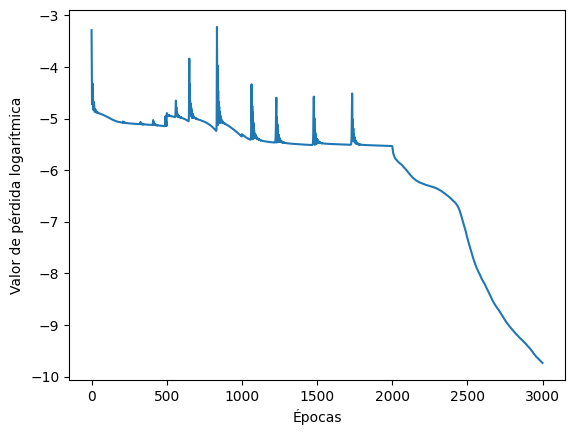

In [ ]:
plt.plot(np.log(loss_list))

# Etiquetar los ejes
plt.xlabel('Épocas')
plt.ylabel('Valor de pérdida logarítmica')

plt.savefig(root + 'loss-PINN-NS.pdf', format='pdf')

# Mostrar el gráfico
plt.show()

<ipython-input-64-d793527ca440>:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, cmap='jet')  # 'viridis' es un mapa de colores, pero puedes elegir otro


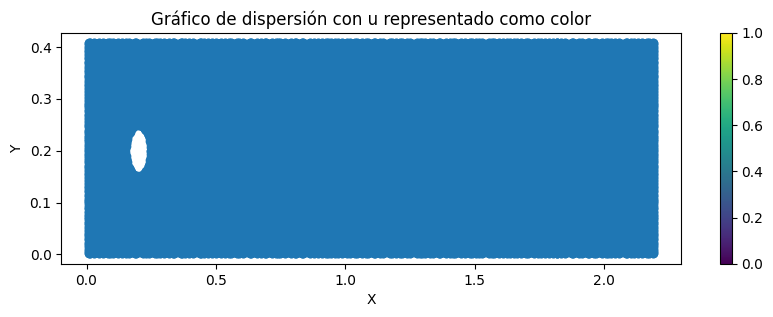

In [ ]:
preds = y_conditions.cpu().detach().numpy()
x = x_collocation.cpu().detach().numpy()
y = y_collocation.cpu().detach().numpy()

u = preds[:, 0]

plt.figure(figsize=(10, 3))
plt.scatter(x, y, cmap='jet')  # 'viridis' es un mapa de colores, pero puedes elegir otro
plt.colorbar()  # Muestra la barra de color que corresponde a los valores de 'u'
plt.xlabel('X')  # Etiqueta del eje X
plt.ylabel('Y')  # Etiqueta del eje Y
plt.title('Gráfico de dispersión con u representado como color')
plt.show()

<ipython-input-48-1e4f9dcfe01c>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_train, y_train, cmap='jet')


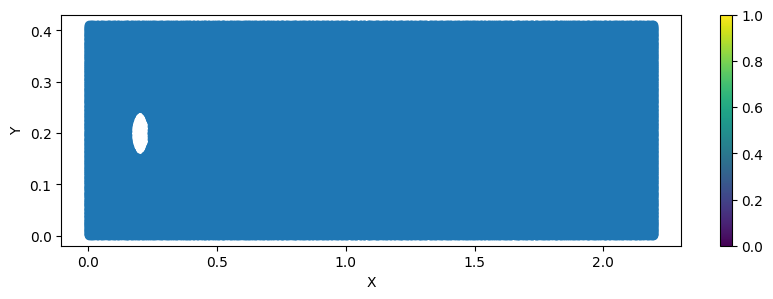

In [ ]:
n_test = 300
x_collocation_test, y_collocation_test = get_collocation_points(n_test, circle_center_x, circle_center_y, circle_radius)

In [ ]:
root = '/content/drive/MyDrive/PINN/NS_models'

### Generación de predicciones para datos de prueba

In [ ]:
mask_circle = circle_condition(circle_center_x, circle_center_y, circle_radius, x_collocation_test, y_collocation_test)
x_collocation_masked = x_collocation_test
x_collocation_masked = torch.hstack((x_collocation_test, y_collocation_test))
x_collocation_masked = x_collocation_masked.to(device)

preds_normal = model(x_collocation_masked).cpu().detach().numpy()
x = x_collocation_masked[:, 0].cpu().detach().numpy()
y = x_collocation_masked[:, 1].cpu().detach().numpy()
u_n = preds_normal[:, 0]
v_n = preds_normal[:, 1]
p_n = preds_normal[:, 2]

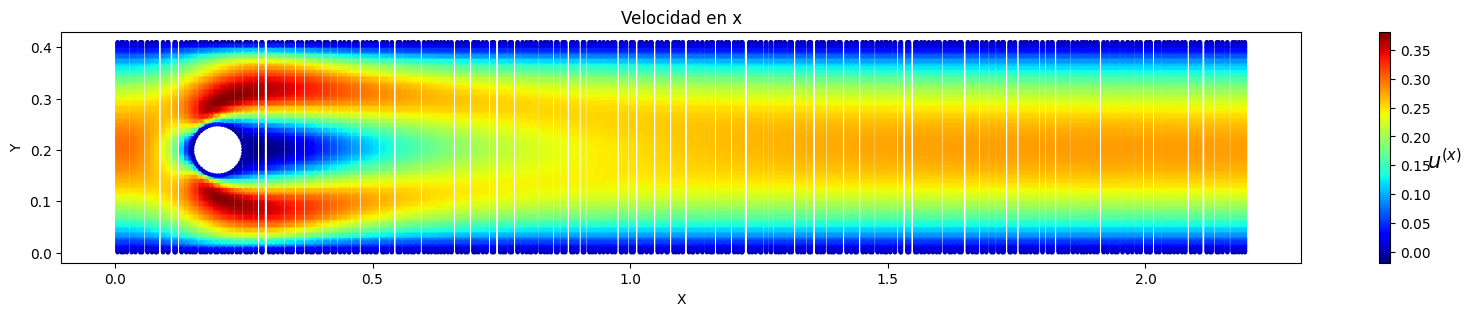

In [ ]:
plt.figure(figsize=(20, 3))
scatter = plt.scatter(x, y, c=u_n, cmap='jet', s=5)
cbar = plt.colorbar(scatter)  # Muestra la barra de color

# Añadir descripción horizontal a la barra de color
cbar.set_label(r'$u^{(x)}$', fontsize=15, rotation=0, labelpad=10)  # labelpad ajusta la distancia del texto a la barra

# Etiquetas y título
plt.xlabel('X')  # Etiqueta del eje X
plt.ylabel('Y')  # Etiqueta del eje Y
plt.title(r'Velocidad en x')

plt.savefig(root + 'ux-PINN-NS.pdf', format='pdf')

# Mostrar el gráfico
plt.show()

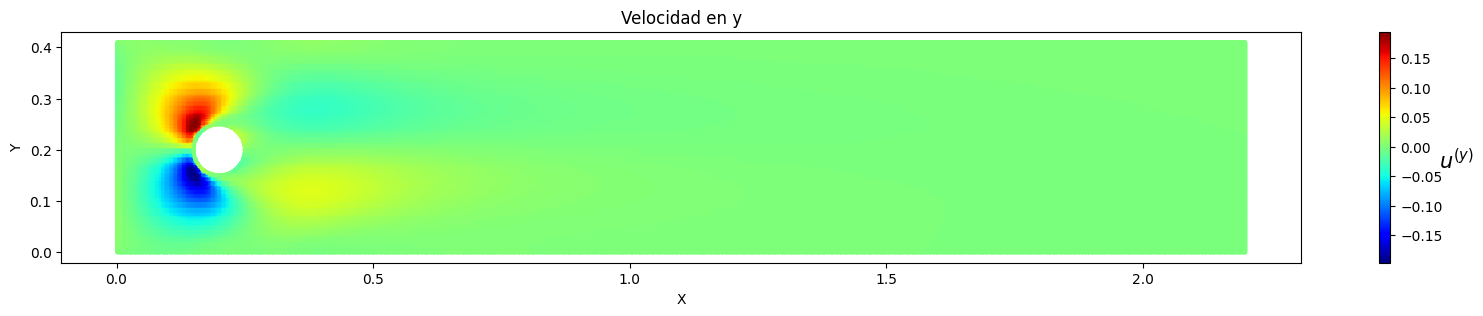

In [ ]:
plt.figure(figsize=(20, 3))
scatter = plt.scatter(x, y, c=v_n, cmap='jet', s=5)
cbar = plt.colorbar(scatter)  # Muestra la barra de color

# Añadir descripción horizontal a la barra de color
cbar.set_label(r'$u^{(y)}$', fontsize=15, rotation=0, labelpad=10)  # labelpad ajusta la distancia del texto a la barra
plt.xlabel('X')  # Etiqueta del eje X
plt.ylabel('Y')  # Etiqueta del eje Y
plt.title('Velocidad en y')

plt.savefig(root + 'uy-PINN-NS.pdf', format='pdf')

plt.show()

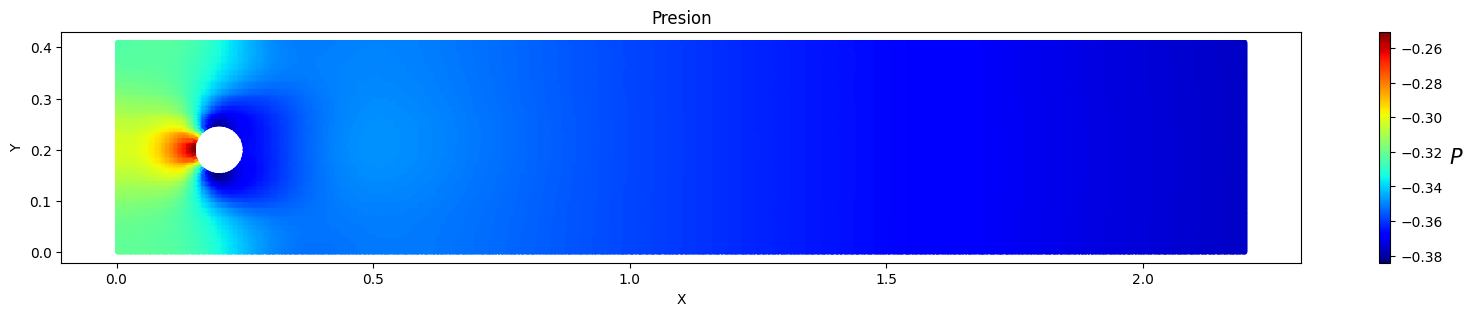

In [ ]:
plt.figure(figsize=(20, 3))
scatter = plt.scatter(x, y, c=p_n, cmap='jet', s=5)
cbar = plt.colorbar(scatter)  # Muestra la barra de color

# Añadir descripción horizontal a la barra de color
cbar.set_label(r'$P$', fontsize=15, rotation=0, labelpad=10)  # labelpad ajusta la distancia del texto a la barra
plt.xlabel('X')  # Etiqueta del eje X
plt.ylabel('Y')  # Etiqueta del eje Y
plt.title('Presion')

plt.savefig(root + 'p-PINN-NS.pdf', format='pdf')

plt.show()